1\. **Hurricanes per Year**

The number of hurricanes in 2005 was 15. The historic average is 6.3. Is this number significantly different?
- Assume the number of hurricanes is random, i.e. follows the Poisson distribution.
- Assume as statistically significant a probability that has a Z score of 3 or larger with respect a normal distribution.

**Hint**: compute the probability that in a single year are observed 15 or more hurricances.

First of all, I want to find the probability that has a Z score of 3 or larger with respect a normal distribution. This is our significance level, so the $\alpha_{value}$.

alpha-value = 0.00135


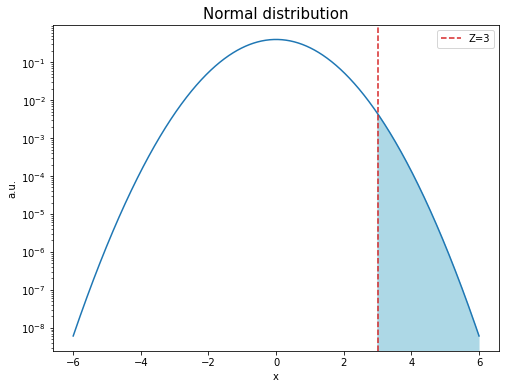

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

Z = 3

# plot the test statistics and its pdf
xs = np.linspace(-6, +6, 1000)
ts = stats.norm.pdf(xs)
plt.figure(figsize=(8, 6))
plt.plot(xs, ts)
plt.fill_between(xs, ts, where=xs > np.abs(Z), color='lightblue')
plt.axvline(Z, linestyle='--', color='C3', label='Z=3')
plt.ylabel("a.u.")
plt.xlabel("x")
plt.yscale("log")
plt.title('Normal distribution', fontsize=15)
plt.legend()

# calculate the p-value as the sum of the left tail + the right tail
alphavalue = 1. - stats.norm.cdf(Z)
print("alpha-value = %0.5f" %alphavalue)

So, the significance level is equal to $0.00135$. If the probability that in a single year are observed 15 or more hurricances (so the $p_value$) is less than $\alpha_{value}$, than the event (15 hurricanes in 2005) is statistically significant. 

Let's compute this probability.

p-value = 0.00084


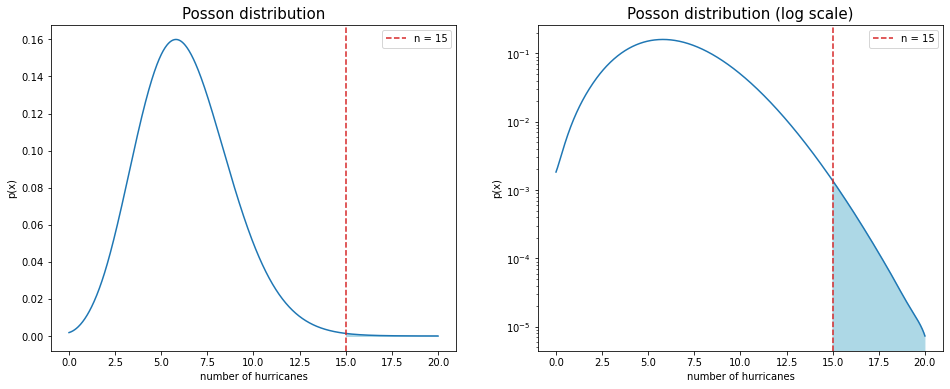

In [54]:
mu = 6.3
x0 = 15

pvalue = 1 - stats.poisson.cdf(x0, mu)
print("p-value = %0.5f" %pvalue)

# plot the distribution
xp = np.arange(0, 21, 1)
tp = stats.poisson.pmf(xp, mu)
# make it smoother
from scipy import interpolate
xplot = np.linspace(0, 20, 1000)
tplot = interpolate.splev(xplot, interpolate.splrep(xp, tp, s=0))
# plot
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 6))
ax0.plot(xplot, tplot)
ax0.fill_between(xplot, tplot, where=xplot > x0, color='lightblue')
ax0.axvline(x0, linestyle='--', color='C3', label='n = 15')
ax0.set_ylabel("p(x)")
ax0.set_xlabel("number of hurricanes")
ax0.set_title('Posson distribution', fontsize=15)
ax0.legend()

# log scale
ax1.plot(xplot, tplot)
ax1.fill_between(xplot, tplot, where=xplot > x0, color='lightblue')
ax1.axvline(x0, linestyle='--', color='C3', label='n = 15')
ax1.set_ylabel("p(x)")
ax1.set_xlabel("number of hurricanes")
ax1.set_yscale("log")
ax1.set_title('Posson distribution (log scale)', fontsize=15)
ax1.legend();


The probability that in a single year are observed 15 or more hurricances is $0.00084$. The value is very small, so already from this we could say that the event is statistically significant (under the assumptions made). 

If we compare the $p_{value}$ with the significal level previously computed, we get
$
 p_{value} = 0.00084 < \alpha_{value} = 0.00135
$
and indeed the event of having 15 hurricanes in a year is statistically significant.

2\. **Pairwise t-test**

In an experiment, a group of 10 individuals agreed to participate in a study of blood pressure changes following exposure to halogen lighting. Resting systolic blood pressure was recorded for each individual. The participants were then exposed to 20 minutes in a room lit only by halogen lamps. A post-exposure systolic blood pressure reading was recorded for each individual. The results are presented in the following data set:

```python
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])
```

Determine whether the change in blood pressures within our sample was statistically significant.

**Hint:**
in this case, the Student's $t$-test should be performed to compare the two datasets.
Use the following test statistics:

$$T = \frac{\bar{x}_1 - \bar{x}_2}{\sigma \sqrt{\frac{2}{n}}}$$

and 

$$\sigma = \sqrt{\frac{\sigma_1^2 + \sigma_2^2}{2}}$$

I choose $\alpha=0.05$

pre mean: 116.70, 
post mean: 135.40

T = -3.786997938137629
p-value = 0.00430


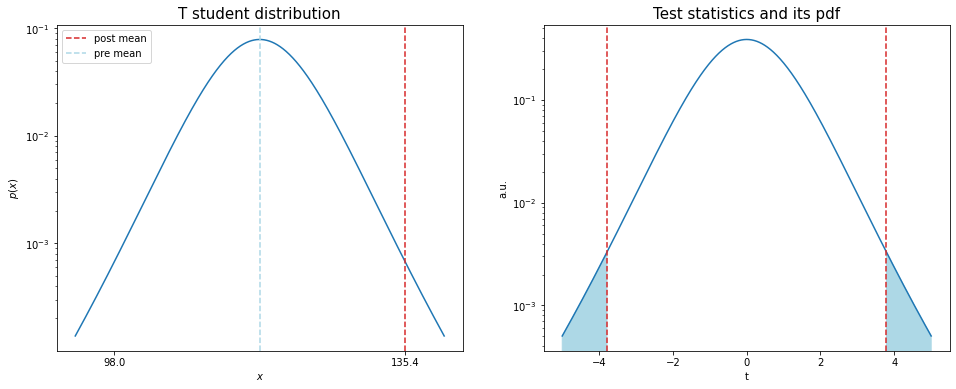

In [55]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# data
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])

# means (pre --> x1, post --> x2)
x1_mean = pre.mean()
x2_mean = post.mean()
print('pre mean: %.2f, \npost mean: %.2f' %(x1_mean, x2_mean))

# compute std
n = pre.size
var1 = np.var(pre, ddof=1)
var2 = np.var(post, ddof=1)

std = np.sqrt((var1+var2)/2)

# T
T = (x1_mean-x2_mean)/(std*np.sqrt(2/n))
print("\nT =", T)

# plot the T student distribution and the pre/post mean
w = abs(x1_mean-x2_mean)
x = np.linspace(x1_mean - w - 5, x1_mean + w + 5, 1000)

y = stats.t.pdf(x, loc=x1_mean, scale=std*np.sqrt(2/n), df=n - 1)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 6))
ax0.plot(x, y)
ax0.axvline(x2_mean, linestyle='--', color='C3', label='post mean')
ax0.axvline(x1_mean, linestyle='--', color='lightblue', label='pre mean')
ax0.set_xticks([x1_mean - w, x1_mean + w])
ax0.set_ylabel("$p(x)$")
ax0.set_xlabel("$x$")
ax0.set_yscale("log")
ax0.set_title("T student distribution", fontsize=15)
ax0.legend()

# plot the test statistics and its pdf
xs = np.linspace(-5, +5, 1000)
ts = stats.t.pdf(xs, n - 1)
ax1.plot(xs, ts)
ax1.fill_between(xs, ts, where=np.abs(xs) > np.abs(T), color='lightblue')
ax1.axvline(T, linestyle='--', color='C3')
ax1.axvline(-T, linestyle='--', color='C3')
ax1.set_ylabel("a.u.")
ax1.set_xlabel("t")
ax1.set_yscale("log")
ax1.set_title("Test statistics and its pdf", fontsize=15)

# now we calculate the p-value. Since it's double sided:
pvalue = stats.t.cdf(T, n - 1) + (1. - stats.t.cdf(-T, n - 1))
print("p-value = %0.5f" %pvalue)


Since the $p_{value}<\alpha$, where $\alpha=0.05$, the change in blood pressures is statistically significant. We reject the null-hypotesis that the obtained results are from the same distribution.

3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

,Hares,Lynxes,Carrots
1900.0,30000.0,4000.0,48300.0
1901.0,47200.0,6100.0,48200.0
1902.0,70200.0,9800.0,41500.0
1903.0,77400.0,35200.0,38200.0
1904.0,36300.0,59400.0,40600.0


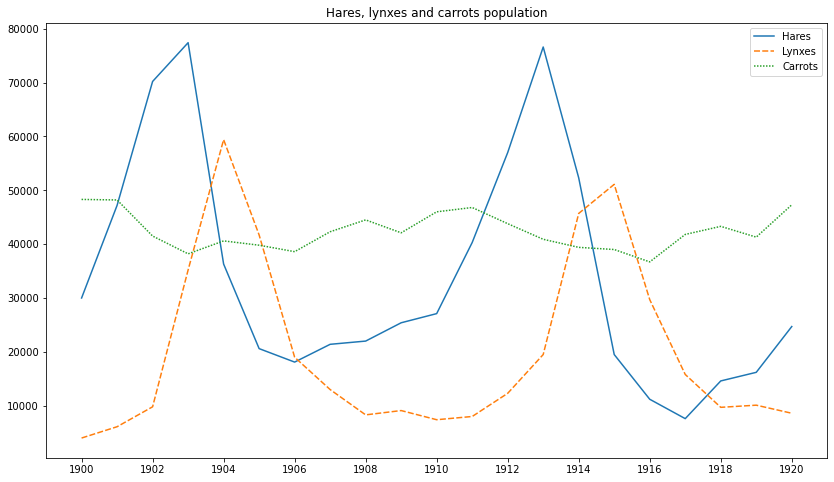

In [56]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

species = np.array(['Hares', 'Lynxes', 'Carrots'])
data = np.loadtxt('populations.txt')
dataframe = pd.DataFrame(data[:, 1:], columns=species, index=data[:,0]) # the first line is commented
display(dataframe.head())

fig, ax = plt.subplots(figsize=(14,8))
sns.lineplot(data=dataframe)
ax.set_title('Hares, lynxes and carrots population')
ax.xaxis.set_major_locator(MultipleLocator(2)) 


Period of the hares population: 10.50 years
Period of the lynxes population: 10.50 years
Period of the carrots population: 10.50 years


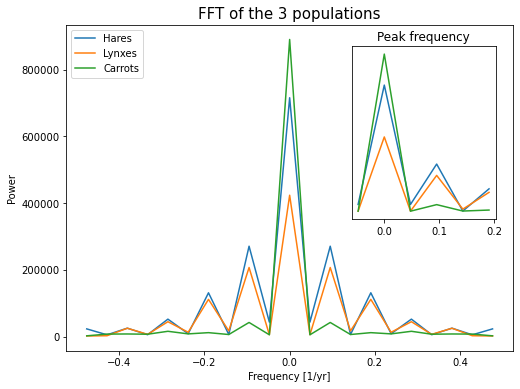

In [57]:
from scipy import fftpack
from scipy import signal

def FFT_analysis(population, verbose=False, inverse=False, plot_title=''):
    time_step = 1

    # FFT of the population
    pop_fft = fftpack.fft(population)
    
    # Power 
    power = np.abs(pop_fft) 

    # Return the corresponding frequencies
    sample_freq = fftpack.fftfreq(population.size, d=time_step)
    sort_freq = sample_freq.argsort()
   
    # Find the peak frequency
    pos_mask = np.where(sample_freq > 0) # the peak in 0 is not significant (null frequency), we only care about the second one

    peak_freq = sample_freq[pos_mask][power[pos_mask].argmax()] 
    if verbose: print("Peak frequency: %.4f" %peak_freq)
    
    # Calculate the IFFT
    if inverse:
        high_pop_fft = pop_fft.copy()
        high_pop_fft[np.abs(sample_freq) > peak_freq] = 0
        
        filtered_behaviour = np.real(fftpack.ifft(high_pop_fft))
        return peak_freq, sample_freq[sort_freq], power[sort_freq], filtered_behaviour
    else:
        return peak_freq, sample_freq[sort_freq], power[sort_freq]
        
hares_freq, hares_sf, hares_pw, hares_filtered = FFT_analysis(dataframe['Hares'].values, inverse=True)
print('Period of the hares population: %.2f years' %(1/hares_freq))
lynxes_freq, lynxes_sf, lynxes_pw, lynxes_filtered = FFT_analysis(dataframe['Lynxes'].values, inverse=True)
print('Period of the lynxes population: %.2f years' %(1/lynxes_freq))
carrots_freq, carrots_sf, carrots_pw, carrots_filtered = FFT_analysis(dataframe['Carrots'].values, inverse=True)
print('Period of the carrots population: %.2f years' %(1/carrots_freq))

# Plot the FFT powers
plt.figure(figsize=(8, 6))
plt.plot(hares_sf, hares_pw, label='Hares', color='C0')
plt.plot(lynxes_sf, lynxes_pw, label='Lynxes', color='C1')
plt.plot(carrots_sf, carrots_pw, label='Carrots', color='C2')
plt.xlabel('Frequency [1/yr]')
plt.ylabel('Power')
plt.title('FFT of the 3 populations', fontsize=15)
plt.legend(loc='upper left')

axes = plt.axes([0.62, 0.43, 0.25, 0.4])
plt.title('Peak frequency')
plt.plot(hares_sf[9:15], hares_pw[9:15])
plt.plot(lynxes_sf[9:15], lynxes_pw[9:15])
plt.plot(carrots_sf[9:15], carrots_pw[9:15])
plt.setp(axes, yticks=[]);


The populations have the same peak frequency, so the same period, $T=10.50yrs$. Let's remove all frequencies except from the peak one and plot the filtered behaviour of each population.  

<Figure size 576x432 with 0 Axes>

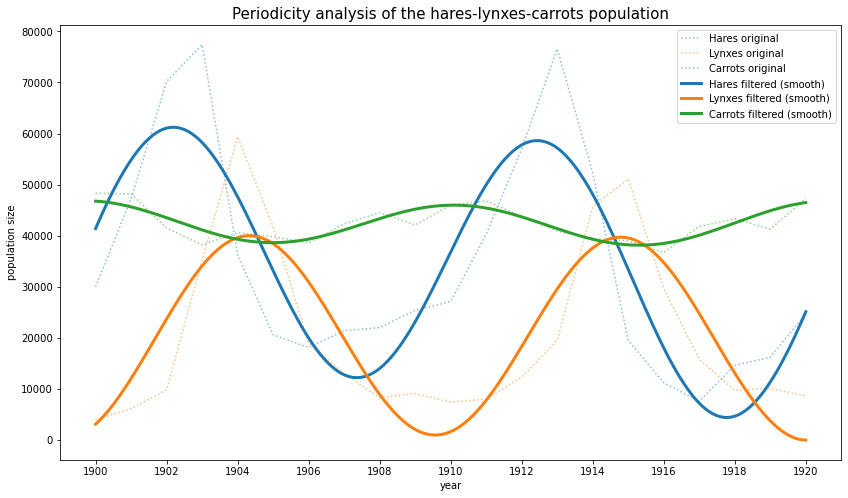

In [58]:
from scipy import interpolate

# Plot the result of the IFFT
plt.figure(figsize=(8, 6))

fig, ax = plt.subplots(figsize=(14,8))
for popidx, col in zip(dataframe.columns, ['C0', 'C1', 'C2']):
    ax.plot(dataframe.index, dataframe[popidx], label=popidx+' original', color=col, alpha=0.5, linestyle='dotted')
    
ax.set_title('Periodicity analysis of the hares-lynxes-carrots population', fontsize=15)
ax.xaxis.set_major_locator(MultipleLocator(2)) 

time_vec=np.linspace(dataframe.index[0], dataframe.index[-1], 200)

for pop, popidx, col in zip([interpolate.splev(time_vec, interpolate.splrep(dataframe.index, hares_filtered, s=0)),
                             interpolate.splev(time_vec, interpolate.splrep(dataframe.index, lynxes_filtered, s=0)),
                             interpolate.splev(time_vec, interpolate.splrep(dataframe.index, carrots_filtered, s=0))],                                               
                            dataframe.columns, ['C0', 'C1', 'C2']):
    ax.plot(time_vec, pop, label=popidx+' filtered (smooth)', linewidth=3, color=col)
    
ax.set_xlabel('year')
ax.set_ylabel('population size')
ax.legend();

4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

(474, 630)


Text(0.5, 1.0, 'Filtered image')

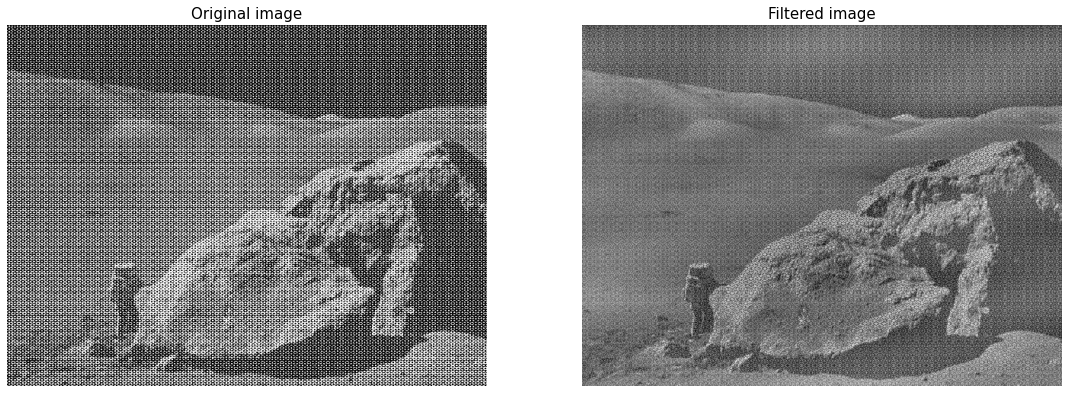

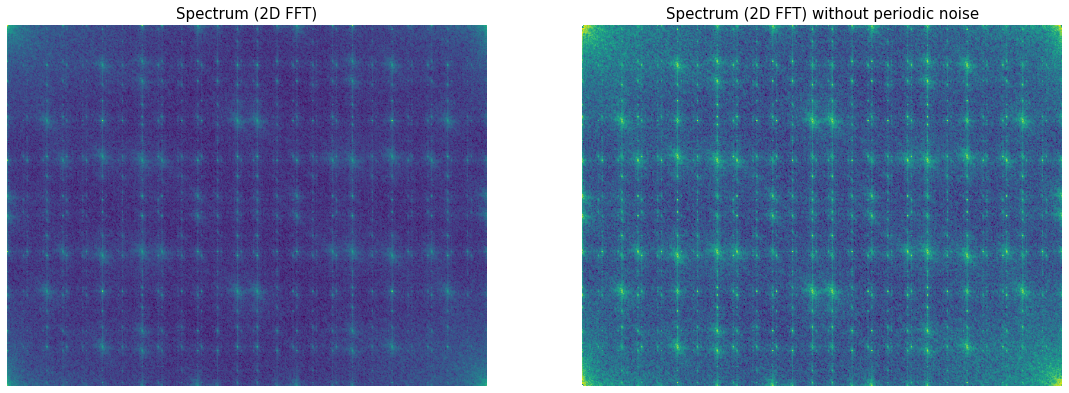

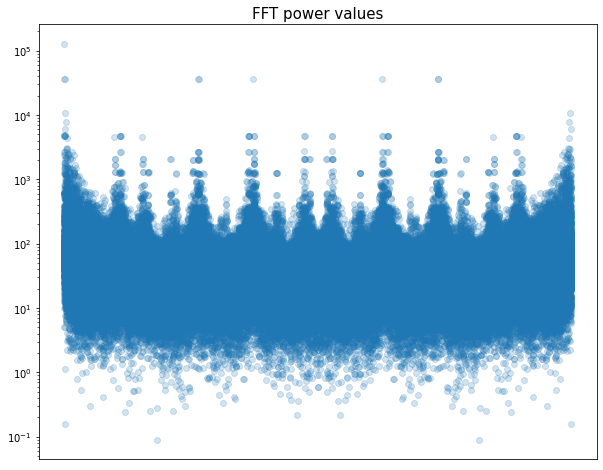

In [59]:
from matplotlib.colors import LogNorm

image = plt.imread("moonlanding.png")
fig_image, (im1, im2) = plt.subplots(1, 2, figsize=(18.9, 7.11))
im1.imshow(image, cmap = 'gray');
im1.set_title('Original image', fontsize=15)
im1.axis('off')
im2.axis('off')

print(image.shape)

# 2D FFT of the image
image_fft = fftpack.fft2(image)

# Power
power = np.abs(image_fft)

# Plot the spectrum
fig_spec, (sp1, sp2) = plt.subplots(1, 2, figsize=(18.9, 7.11))
sp1.axis('off')
sp2.axis('off')

sp1.set_title('Spectrum (2D FFT)', fontsize=15)
sp1.imshow(power, norm=LogNorm(vmin=5))

# Inspect the spectrum
fig3, ax = plt.subplots(figsize=(10, 8))
ax.scatter(np.arange(298620), power.flatten(), alpha=0.2)
ax.set_yscale('log')
ax.set_xticks([])
ax.set_title('FFT power values', fontsize=15)

# Set the noise regions to zero
filt_image_fft = image_fft.copy()
filt_image_fft[power>2500]=0

# Plot the spectrum without noise
sp2.set_title('Spectrum (2D FFT) without periodic noise', fontsize=15)
sp2.imshow(np.abs(filt_image_fft), norm=LogNorm(vmin=5))

# Inverse Fourier transform
filtered_image = np.real(fftpack.ifft2(filt_image_fft))

# Plot the resulting image
im2.imshow(filtered_image, cmap = 'gray');
im2.set_title('Filtered image', fontsize=15)
